In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

Using TensorFlow backend.


In [2]:
df = pd.read_csv("RELIANCE.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Date.1
Date,,,,,,,,,,,,,,,
2019-11-08,RELIANCE,EQ,1458.60,1449.00,1459.65,1441.30,1446.00,1445.50,1448.50,5494844,7.959284e+14,141759.0,2437863,0.4437,2019-11-08
2019-11-11,RELIANCE,EQ,1445.50,1439.10,1444.25,1422.55,1427.80,1427.80,1431.40,5192423,7.432416e+14,145722.0,2643548,0.5091,2019-11-11
2019-11-13,RELIANCE,EQ,1427.80,1430.00,1475.90,1430.00,1469.10,1472.30,1460.74,11532364,1.684575e+15,213111.0,4972794,0.4312,2019-11-13
2019-11-14,RELIANCE,EQ,1472.30,1476.00,1481.60,1455.80,1458.25,1462.75,1466.92,6518339,9.561881e+14,127557.0,2601168,0.3991,2019-11-14
2019-11-15,RELIANCE,EQ,1462.75,1465.65,1486.80,1463.15,1466.80,1470.85,1476.84,7173674,1.059434e+15,152000.0,3241407,0.4518,2019-11-15


In [3]:
columns=['Prev Close','Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']

In [4]:
df_final= df[columns]
df_final.tail()

,Prev Close,Open,High,Low,Close,Volume,Turnover
Date,,,,,,,
2019-11-08,1458.60,1449.00,1459.65,1441.30,1445.50,5494844,7.959284e+14
2019-11-11,1445.50,1439.10,1444.25,1422.55,1427.80,5192423,7.432416e+14
2019-11-13,1427.80,1430.00,1475.90,1430.00,1472.30,11532364,1.684575e+15
2019-11-14,1472.30,1476.00,1481.60,1455.80,1462.75,6518339,9.561881e+14
2019-11-15,1462.75,1465.65,1486.80,1463.15,1470.85,7173674,1.059434e+15


In [5]:
df_final.describe()

,Prev Close,Open,High,Low,Close,Volume,Turnover
count,2710.000000,2710.000000,2710.000000,2710.000000,2710.000000,2.710000e+03,2.710000e+03
mean,1060.635683,1061.642565,1074.778561,1047.887897,1060.750904,4.762714e+06,5.199070e+14
std,302.638785,303.228074,309.570366,296.374499,302.737295,3.226612e+06,4.105453e+14
min,676.100000,675.000000,682.800000,673.050000,676.100000,5.282000e+04,9.037442e+12
25%,872.450000,872.925000,882.862500,861.437500,872.450000,2.814556e+06,2.633174e+14
50%,985.875000,987.100000,996.300000,976.900000,985.875000,3.947585e+06,3.931015e+14
75%,1105.000000,1107.712500,1122.750000,1092.075000,1105.000000,5.718546e+06,6.413804e+14
max,2367.550000,2450.000000,2535.000000,2305.250000,2367.550000,4.792344e+07,6.109290e+15


In [6]:
df_final.isnull().values.any()

False

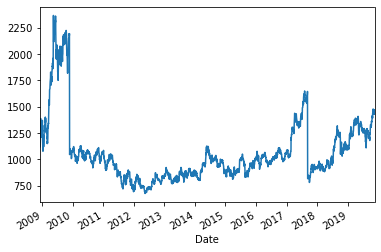

In [8]:
df_final['Close'].plot()

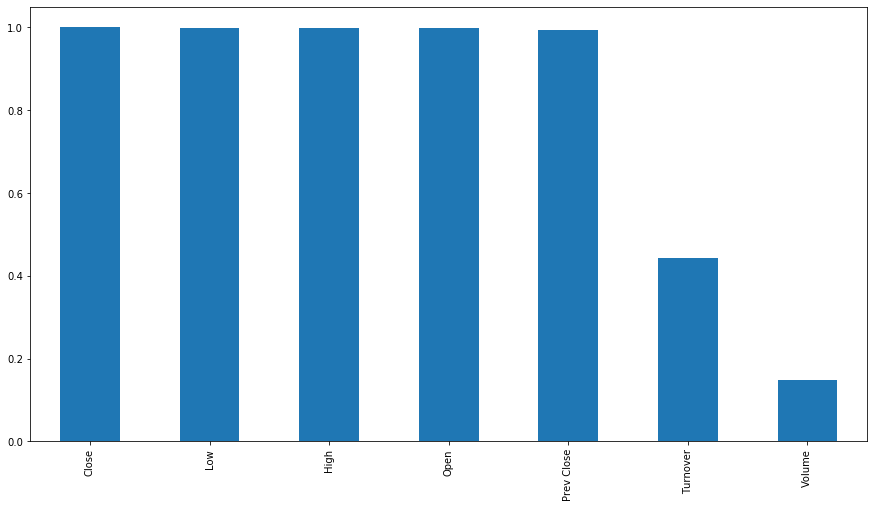

In [9]:
# Plotting Correlation of "Churn" with predictors
plt.figure(figsize=(15,8))
df_final.corr()['Close'].sort_values(ascending = False).plot(kind='bar')

In [10]:
test = df_final
# Target column
target = pd.DataFrame(test['Close'])
test.head()

,Prev Close,Open,High,Low,Close,Volume,Turnover
Date,,,,,,,
2008-12-05,1159.10,1175.0,1182.0,1103.00,1117.60,6679613,7.608186e+14
2008-12-08,1117.60,1152.2,1174.7,1107.00,1118.55,6965801,7.969165e+14
2008-12-10,1118.55,1148.7,1234.0,1137.00,1227.20,7518930,8.932654e+14
2008-12-11,1227.20,1250.0,1297.7,1193.30,1259.00,9088095,1.114063e+15
2008-12-12,1259.00,1240.0,1324.0,1206.25,1307.10,9928592,1.264385e+15


In [11]:
# selecting Feature Columns
feature_columns=['Prev Close','Open', 'High', 'Low', 'Volume', 'Turnover']

In [12]:
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Prev Close,Open,High,Low,Volume,Turnover
Date,,,,,,
2008-12-05,0.285554,0.281690,0.269517,0.263417,0.138431,0.123238
2008-12-08,0.261019,0.268845,0.265576,0.265868,0.144410,0.129155
2008-12-10,0.261580,0.266873,0.297592,0.284248,0.155964,0.144949
2008-12-11,0.325815,0.323944,0.331984,0.318742,0.188744,0.181144
2008-12-12,0.344616,0.318310,0.346183,0.326676,0.206301,0.205786


In [13]:
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target.shape)

Shape of features :  (2710, 6)
Shape of target :  (2710, 1)


In [14]:
# Shift target array because we want to predict the n + 1 day value
target = target.shift(-1)

In [15]:
# # Taking last 90 rows of data to be validation set
# validation_X = feature_minmax_transform[-90:-1]
# feature_minmax_transform = feature_minmax_transform[:-90]
# display(validation_X.tail())
# display(validation_y.tail())

In [16]:
print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target.shape)
display(target.tail())


 -----After process------ 

Shape of features :  (2710, 6)
Shape of target :  (2710, 1)


,Close
Date,
2019-11-08,1427.80
2019-11-11,1472.30
2019-11-13,1462.75
2019-11-14,1470.85
2019-11-15,NaN


In [17]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target[:len(train_index)].values.ravel(), target[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [18]:
X_train.shape

(2464, 6)

In [19]:
pd.DataFrame(feature_minmax_transform).tail()

,Prev Close,Open,High,Low,Volume,Turnover
Date,,,,,,
2019-11-08,0.462621,0.436056,0.419420,0.470684,0.113682,0.128993
2019-11-11,0.454876,0.430479,0.411106,0.459196,0.107364,0.120356
2019-11-13,0.444412,0.425352,0.428193,0.463761,0.239804,0.274667
2019-11-14,0.470720,0.451268,0.431271,0.479567,0.135062,0.155264
2019-11-15,0.465074,0.445437,0.434078,0.484071,0.148752,0.172189


In [20]:
pd.DataFrame(X_test).tail()

,Prev Close,Open,High,Low,Volume,Turnover
Date,,,,,,
2019-11-08,0.462621,0.436056,0.419420,0.470684,0.113682,0.128993
2019-11-11,0.454876,0.430479,0.411106,0.459196,0.107364,0.120356
2019-11-13,0.444412,0.425352,0.428193,0.463761,0.239804,0.274667
2019-11-14,0.470720,0.451268,0.431271,0.479567,0.135062,0.155264
2019-11-15,0.465074,0.445437,0.434078,0.484071,0.148752,0.172189


In [21]:
X_test.shape

(246, 6)

In [22]:
y_train.shape

(2464,)

In [23]:
y_test.shape

(246,)

In [24]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

In [25]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [26]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

K.clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)


history_model_lstm = model_lstm.fit(X_tr_t, y_train, validation_data=(X_tst_t,y_test), epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

W1125 03:36:51.393395   568 deprecation_wrapper.py:119] From C:\Anaconda\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1125 03:36:51.393395   568 deprecation_wrapper.py:119] From C:\Anaconda\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1125 03:36:51.408568   568 deprecation_wrapper.py:119] From C:\Anaconda\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1125 03:36:51.424188   568 deprecation_wrapper.py:119] From C:\Anaconda\envs\tf-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1125 03:36:51.424188   568 depr

Epoch 1/200
2464/2464 [==============================] - 4s 2ms/step - loss: 1175739.9881
Epoch 2/200
2464/2464 [==============================] - 2s 659us/step - loss: 1164662.6838
Epoch 3/200
2464/2464 [==============================] - 2s 672us/step - loss: 1137480.1026
Epoch 4/200
2464/2464 [==============================] - 2s 877us/step - loss: 1092619.2441
Epoch 5/200
2464/2464 [==============================] - 2s 1ms/step - loss: 1037928.1925
Epoch 6/200
2464/2464 [==============================] - 2s 1ms/step - loss: 978341.8151
Epoch 7/200
2464/2464 [==============================] - 2s 926us/step - loss: 914449.2252
Epoch 8/200
2464/2464 [==============================] - 2s 913us/step - loss: 847185.7190
Epoch 9/200
2464/2464 [==============================] - 2s 946us/step - loss: 777658.3292
Epoch 10/200
2464/2464 [==============================] - 2s 924us/step - loss: 706992.1323
Epoch 11/200
2464/2464 [==============================] - 2s 856us/step - loss: 636231.490

2464/2464 [==============================] - 3s 1ms/step - loss: 1613.5862
Epoch 182/200
2464/2464 [==============================] - 2s 939us/step - loss: 1613.4293
Epoch 183/200
2464/2464 [==============================] - 2s 964us/step - loss: 1613.2739
Epoch 184/200
2464/2464 [==============================] - 2s 929us/step - loss: 1613.1185
Epoch 185/200
2464/2464 [==============================] - 2s 932us/step - loss: 1612.9641
Epoch 186/200
2464/2464 [==============================] - 2s 955us/step - loss: 1612.8106
Epoch 187/200
2464/2464 [==============================] - 2s 939us/step - loss: 1612.6580
Epoch 188/200
2464/2464 [==============================] - 2s 926us/step - loss: 1612.5057
Epoch 189/200
2464/2464 [==============================] - 2s 933us/step - loss: 1612.3544
Epoch 190/200
2464/2464 [==============================] - 2s 943us/step - loss: 1612.2028
Epoch 191/200
2464/2464 [==============================] - 2s 934us/step - loss: 1612.0519
Epoch 192/200
2

In [27]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test[:-1], y_pred_test_lstm[:-1])))
r2_test = r2_score(y_test, y_pred_test_lstm)

The R2 score on the Train set is:	0.983
The R2 score on the Test set is:	0.929


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [28]:
score_lstm= model_lstm.evaluate(X_tst_t[:-1], y_test[:-1], batch_size=1, verbose=0)
print('LSTM: %f'%score_lstm)

LSTM: 662.216452


In [29]:
y_pred_test_LSTM= model_lstm.predict(X_tst_t)
y_pred_test_LSTM[-1]

array([1464.6882], dtype=float32)

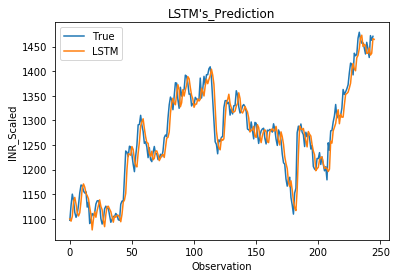

In [30]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [31]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_excel('PredictionResults_LSTM_NonShift.xlsx')

In [37]:
# evaluate the model
train_acc = model_lstm.evaluate(X_tr_t, y_train, verbose=0)
test_acc = model_lstm.evaluate(X_tst_t[:-1], y_test[:-1], verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 1604.589, Test: 662.217


KeyError: 'val_loss'

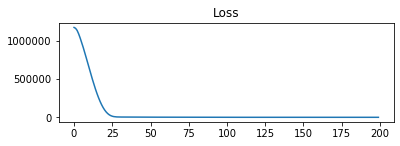

In [40]:
# plot loss during training
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history_model_lstm.history['loss'], label='train')
pyplot.plot(history_model_lstm.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history_model_lstm.history['acc'], label='train')
pyplot.plot(history_model_lstm.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
y_p